## IMS mismatch with M1M3 motion system - SITCOM-760

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
import itertools as itt
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import seaborn as sns

from astropy import units as u
from astropy.time import Time, TimezoneInfo

from lsst.sitcom import vandv
from lsst.ts.idl.enums import MTM1M3

In [6]:
# Define time frame to retrieve data in the EFD database
t_start = Time("2023-05-30T04:35:00", format="isot", scale="utc")
t_end = Time("2023-05-30T05:30:00", format="isot", scale="utc")

In [7]:
# Create client to access the EFD database
client = vandv.efd.create_efd_client()

In [8]:
pos_columns = [a + "Position" for a in "xyz"]
rot_columns = [a + "Rotation" for a in "xyz"]
all_columns = pos_columns + rot_columns

In [9]:
# get IMS data
df_ims = await client.select_time_series(
    "lsst.sal.MTM1M3.imsData", 
    "*", t_start, t_end)

df_ims = df_ims.set_index("private_rcvStamp")
df_ims.index = pd.to_datetime(df_ims.index, unit="s")

df_ims = df_ims[all_columns]

# Convert meter to milimeter to make is easier to analyse
df_ims[pos_columns] = df_ims[pos_columns]*u.m.to(u.mm)

In [10]:
# get command positions
df_cmdPos = await client.select_time_series(
    "lsst.sal.MTM1M3.command_positionM1M3", 
    "*", t_start, t_end)

df_cmdPos = df_cmdPos.set_index("private_rcvStamp")
df_cmdPos.index = pd.to_datetime(df_cmdPos.index, unit="s")
df_cmdPos = df_cmdPos[all_columns]
df_cmdPos[pos_columns] = df_cmdPos[pos_columns]*u.m.to(u.mm)

In [11]:
# get Hard Point state

df_HPState = await client.select_time_series(
    "lsst.sal.MTM1M3.logevent_hardpointActuatorState", 
    "*", t_start, t_end)

df_HPState = df_HPState.set_index("private_rcvStamp")
df_HPState.index = pd.to_datetime(df_HPState.index, unit="s")

In [12]:
# get Hard Point Data
df_HPData = await client.select_time_series(
    "lsst.sal.MTM1M3.hardpointActuatorData", 
    "*", t_start, t_end)

df_HPData = df_HPData.set_index("private_rcvStamp")
df_HPData.index = pd.to_datetime(df_HPData.index, unit="s")

df_HPData = df_HPData[all_columns]

# convert positions to mm
df_HPData[pos_columns] = df_HPData[pos_columns]*u.m.to(u.mm)

In [13]:
# Find all the time windows during which the HP is in Standy state (stable)  
mask_HP_stable = (df_HPState[[f"motionState{j}" for j in range(6)]] == 0).all(axis=1) 

delta_t = pd.Timedelta(0.5, "seconds")
time_stable = []

for i, mask in enumerate(mask_HP_stable):
    if mask:
        if i+1 < len(mask_HP_stable) and not mask_HP_stable[mask_HP_stable.index[i+1]]:
            t0 = mask_HP_stable.index[i]
            
# Remove a small time interval at the end of the time window in order to make sure that HP is in Standy state for any ids timestamp 
            t1 = mask_HP_stable.index[i+1] - delta_t
            time_stable.append([t0, t1])

## Data analysis

### We run the analysis in 2 steps, first the positions and second the rotations

## Position analysis

In [14]:
# Store results in a dataframe in order to plot them later
results = pd.DataFrame(columns=["ims_x_mean", "ims_y_mean", "ims_z_mean", "HP_x_mean", "HP_y_mean", "HP_z_mean", 
                                "offset_x_mean", "offset_y_mean", "offset_z_mean", "cmd_x", "cmd_y", "cmd_z"])

for index, time_window in enumerate(time_stable):
    t0 = time_window[0]
    t1 = time_window[1]
    ims_x_mean = np.mean(df_ims[t0:t1]['xPosition'])
    ims_y_mean = np.mean(df_ims[t0:t1]['yPosition'])
    ims_z_mean = np.mean(df_ims[t0:t1]['zPosition'])
    HP_x_mean = np.mean(df_HPData[t0:t1]['xPosition'])
    HP_y_mean = np.mean(df_HPData[t0:t1]['yPosition'])
    HP_z_mean = np.mean(df_HPData[t0:t1]['zPosition'])
    offset_x_mean = ims_x_mean - HP_x_mean
    offset_y_mean = ims_y_mean - HP_y_mean
    offset_z_mean = ims_z_mean - HP_z_mean
    
    # Find timestamp in command position dataframe corresponding to t0
    iloc_idx = df_cmdPos.index.get_indexer([t0], method='pad')
    t_cmdPos = df_cmdPos.index[iloc_idx[0]]
    
    # get command position
    cmd_x = df_cmdPos[t_cmdPos:t_cmdPos]['xPosition'][0]
    cmd_y = df_cmdPos[t_cmdPos:t_cmdPos]['yPosition'][0]
    cmd_z = df_cmdPos[t_cmdPos:t_cmdPos]['zPosition'][0]
    
    # Store results in dataframe
    row = pd.DataFrame({"ims_x_mean":ims_x_mean, "ims_y_mean":ims_y_mean, "ims_z_mean":ims_z_mean, 
                        "HP_x_mean":HP_x_mean, "HP_y_mean":HP_y_mean, "HP_z_mean":HP_z_mean,
                        "offset_x_mean":offset_x_mean, "offset_y_mean":offset_y_mean, "offset_z_mean": offset_z_mean,
                        "cmd_x":cmd_x, "cmd_y":cmd_y, "cmd_z":cmd_z}, index=[index])
    results = pd.concat([results, row])

axes = "xyz"
sigma = {}
mean = {}

for axis in axes:
    sigma[axis] = np.std(results["offset_" + axis + "_mean"])
    mean[axis] = np.mean(results["offset_" + axis + "_mean"])

In [15]:
results

,ims_x_mean,ims_y_mean,ims_z_mean,HP_x_mean,HP_y_mean,HP_z_mean,offset_x_mean,offset_y_mean,offset_z_mean,cmd_x,cmd_y,cmd_z
0,-1.461109,5.512146,-1.388209,0.000000,0.000000e+00,0.000000,-1.461109,5.512146,-1.388209,0.0,0.0,0.0
1,-0.473468,5.471183,-1.393384,0.999919,-9.500117e-07,-0.000188,-1.473387,5.471184,-1.393196,1.0,0.0,0.0
2,-2.449521,5.520565,-1.396925,-0.999919,9.500752e-07,-0.000188,-1.449602,5.520564,-1.396737,-1.0,0.0,0.0
3,-1.479338,6.499647,-1.398382,0.000002,1.000036e+00,-0.000249,-1.479339,5.499611,-1.398133,0.0,1.0,0.0
4,-1.457433,4.521586,-1.394299,-0.000002,-1.000036e+00,-0.000126,-1.457432,5.521622,-1.394173,0.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
92,-1.453090,4.511495,-2.390522,-0.000005,-9.998180e-01,-1.000172,-1.453085,5.511313,-1.390350,0.0,-1.0,-1.0
93,-1.465042,5.506173,-1.382255,0.000001,-3.389537e-05,-0.000248,-1.465044,5.506207,-1.382007,0.0,0.0,0.0
94,-1.463042,5.508030,-1.381187,0.000007,-7.477081e-05,-0.000065,-1.463049,5.508105,-1.381122,0.0,0.0,0.0
95,-1.460582,5.496491,-1.381024,0.000172,-1.079703e-04,-0.000125,-1.460754,5.496599,-1.380899,0.0,0.0,0.0


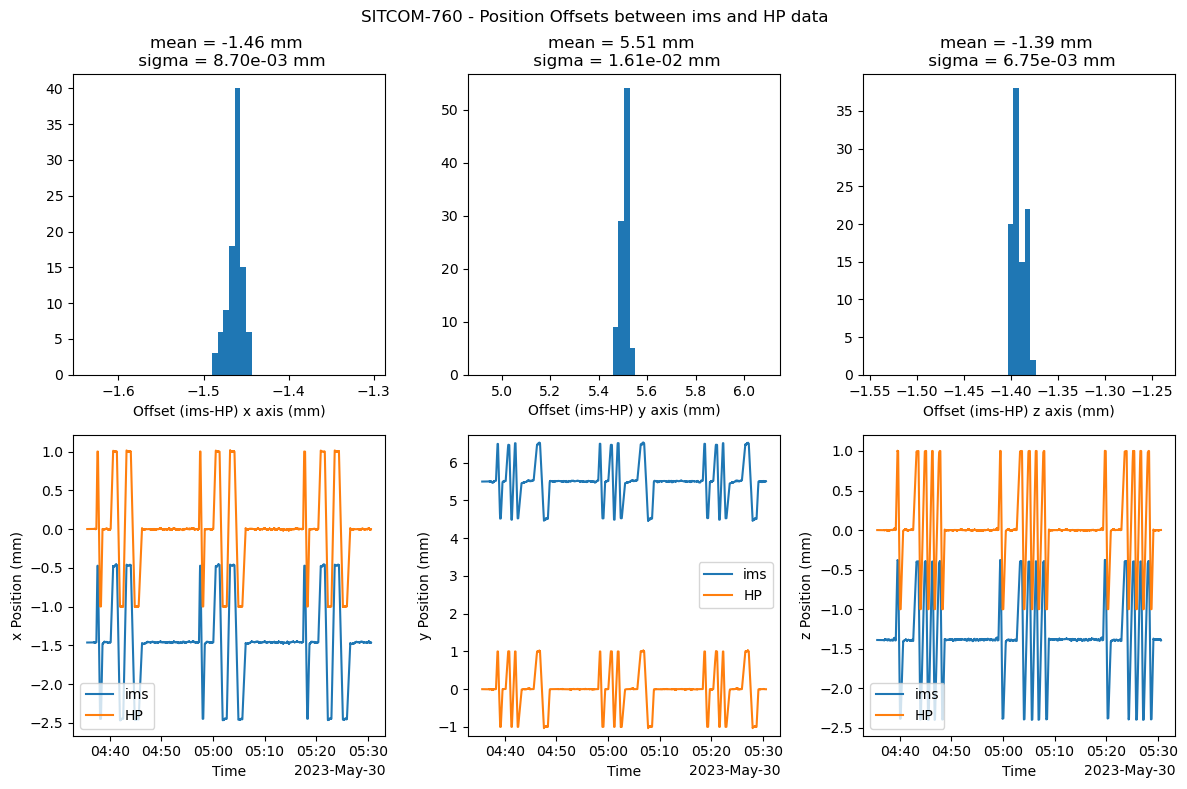

In [16]:
# Plot results for HP position versus IMS position
locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

title = "SITCOM-760 - Position Offsets between ims and HP data"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(12, 8))

axes = "xyz"
for i in range(3):
    max = np.max(results[f"offset_{axes[i]}_mean"])
    min = np.min(results[f"offset_{axes[i]}_mean"])
    axs[0][i].hist(results[f"offset_{axes[i]}_mean"], bins=50, range=[min-0.1*abs(min), max+0.1*abs(max)])
    axs[0][i].set_xlabel(f"Offset (ims-HP) {axes[i]} axis (mm)")
    val_mean = mean[axes[i]]
    val_sigma = sigma[axes[i]]
    axs[0][i].set_title("mean = %.2f mm \n sigma = %.2e mm" %(val_mean, val_sigma))
    
    axs[1][i].plot(df_ims.index, df_ims[axes[i] + "Position"], label="ims")
    axs[1][i].plot(df_HPData.index, df_HPData[axes[i] + "Position"], label = "HP")
    axs[1][i].xaxis.set_major_formatter(formatter)
    max = np.max([np.max(df_ims[axes[i] + "Position"]), np.max(df_HPData[axes[i] + "Position"])])
    min = np.min([np.min(df_ims[axes[i] + "Position"]), np.min(df_HPData[axes[i] + "Position"])])
    axs[1][i].set_ylim([min-0.2, max+0.2])
    axs[1][i].set_xlabel("Time")
    axs[1][i].set_ylabel(f"{axes[i]} Position (mm)")
    axs[1][i].legend()
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.90)

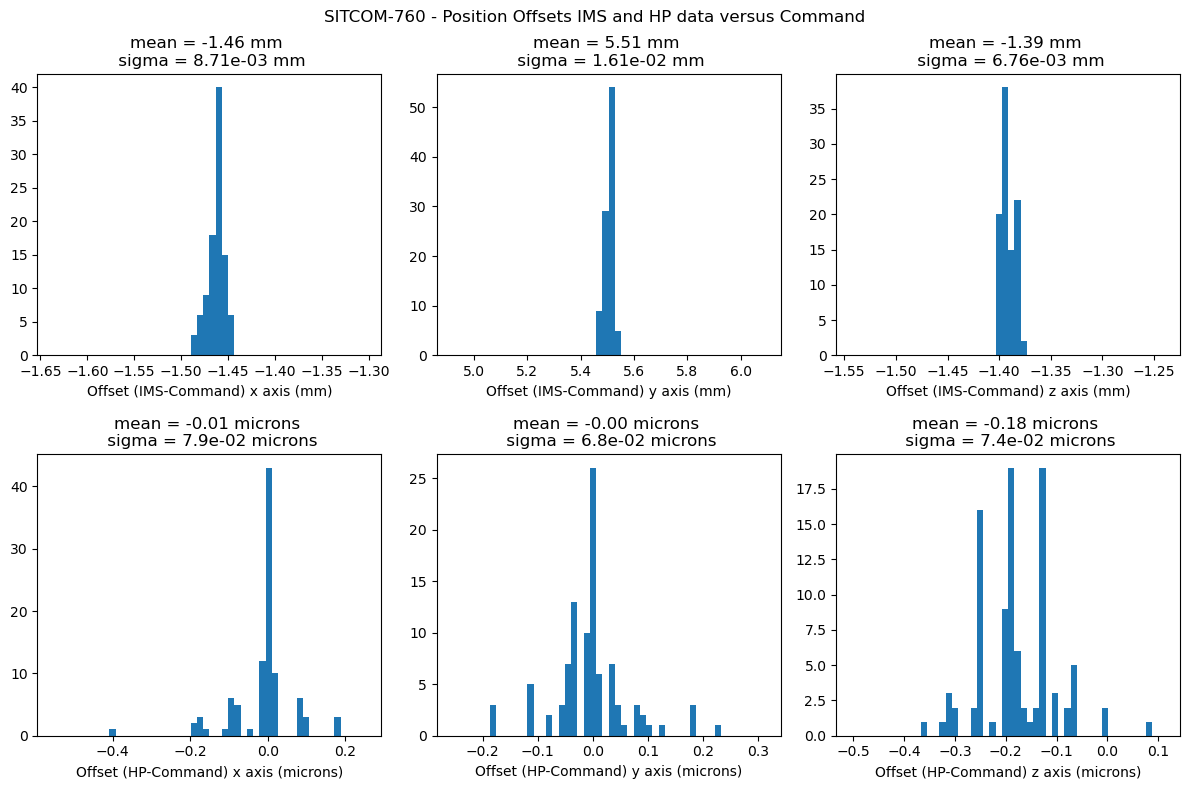

In [17]:
# Plot results for HP position and IMS position w.r.t. command position

title = "SITCOM-760 - Position Offsets IMS and HP data versus Command"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(12, 8))

axes = "xyz"
for i in range(3):
    max = np.max(results[f"ims_{axes[i]}_mean"]-results[f"cmd_{axes[i]}"])
    min = np.min(results[f"ims_{axes[i]}_mean"]-results[f"cmd_{axes[i]}"])
    axs[0][i].hist(results[f"ims_{axes[i]}_mean"]-results[f"cmd_{axes[i]}"], bins=50, range=[min-0.1*abs(min), max+0.1*abs(max)])
    axs[0][i].set_xlabel(f"Offset (IMS-Command) {axes[i]} axis (mm)")
    mean_ims_cmd = np.mean(results[f"ims_{axes[i]}_mean"]-results[f"cmd_{axes[i]}"])
    sigma_ims_cmd = np.std(results[f"ims_{axes[i]}_mean"]-results[f"cmd_{axes[i]}"])
    axs[0][i].set_title("mean = %.2f mm \n sigma = %.2e mm" %(mean_ims_cmd, sigma_ims_cmd))
    
    max = np.max(results[f"HP_{axes[i]}_mean"]-results[f"cmd_{axes[i]}"])*u.mm.to(u.micron)
    min = np.min(results[f"HP_{axes[i]}_mean"]-results[f"cmd_{axes[i]}"])*u.mm.to(u.micron)
    axs[1][i].hist((results[f"HP_{axes[i]}_mean"]-results[f"cmd_{axes[i]}"])*u.mm.to(u.micron), bins=50, range=[min-0.4*abs(min), max+0.4*abs(max)])
    axs[1][i].set_xlabel(f"Offset (HP-Command) {axes[i]} axis (microns)")
    mean_HP_cmd = np.mean((results[f"HP_{axes[i]}_mean"]-results[f"cmd_{axes[i]}"])*u.mm.to(u.micron))
    sigma_HP_cmd = np.std((results[f"HP_{axes[i]}_mean"]-results[f"cmd_{axes[i]}"])*u.mm.to(u.micron))
    axs[1][i].set_title("mean = %.2f microns \n sigma = %.1e microns" %(mean_HP_cmd, sigma_HP_cmd))
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.90)

## Rotations

In [ ]:
# Store results in a dataframe in order to plot them later
results_rot = pd.DataFrame(columns=["ims_xRot_mean", "ims_yRot_mean", "ims_zRot_mean", "HP_xRot_mean", "HP_yRot_mean", "HP_zRot_mean", 
                                "offset_xRot_mean", "offset_yRot_mean", "offset_zRot_mean", "cmd_xRot", "cmd_yRot", "cmd_zRot"])

for index, time_window in enumerate(time_stable):
    t0 = time_window[0]
    t1 = time_window[1]
    ims_xRot_mean = np.mean(df_ims[t0:t1]['xRotation'])
    ims_yRot_mean = np.mean(df_ims[t0:t1]['yRotation'])
    ims_zRot_mean = np.mean(df_ims[t0:t1]['zRotation'])
    HP_xRot_mean = np.mean(df_HPData[t0:t1]['xRotation'])
    HP_yRot_mean = np.mean(df_HPData[t0:t1]['yRotation'])
    HP_zRot_mean = np.mean(df_HPData[t0:t1]['zRotation'])
    offset_xRot_mean = ims_xRot_mean - HP_xRot_mean
    offset_yRot_mean = ims_yRot_mean - HP_yRot_mean
    offset_zRot_mean = ims_zRot_mean - HP_zRot_mean
    
    # Find timestamp in command position dataframe corresponding to t0
    iloc_idx = df_cmdPos.index.get_indexer([t0], method='pad')
    t_cmdPos = df_cmdPos.index[iloc_idx[0]]
    
    # get command position
    cmd_xRot = df_cmdPos[t_cmdPos:t_cmdPos]['xRotation'][0]
    cmd_yRot = df_cmdPos[t_cmdPos:t_cmdPos]['yRotation'][0]
    cmd_zRot = df_cmdPos[t_cmdPos:t_cmdPos]['zRotation'][0]
    
    # Store results in dataframe
    row = pd.DataFrame({"ims_xRot_mean":ims_xRot_mean, "ims_yRot_mean":ims_yRot_mean, "ims_zRot_mean":ims_zRot_mean, 
                        "HP_xRot_mean":HP_xRot_mean, "HP_yRot_mean":HP_yRot_mean, "HP_zRot_mean":HP_zRot_mean,
                        "offset_xRot_mean":offset_xRot_mean, "offset_yRot_mean":offset_yRot_mean, "offset_zRot_mean":offset_zRot_mean,
                        "cmd_xRot":cmd_xRot, "cmd_yRot":cmd_yRot, "cmd_zRot":cmd_zRot}, index=[index])
    results_rot = pd.concat([results_rot, row])

axes = "xyz"
sigma_rot = {}
mean_rot = {}

for axis in axes:
    sigma_rot[axis] = np.std(results_rot["offset_" + axis + "Rot_mean"])
    mean_rot[axis] = np.mean(results_rot["offset_" + axis + "Rot_mean"])

In [ ]:
results_rot

In [ ]:
# Plot results for rotation analysis
locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

title = "SITCOM-760 Rotations Offsets between IMS and HP data"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(12, 8))

axes = [ "x", "y", "z"]
for i in range(3):
    max = np.max(results_rot[f"offset_{axes[i]}Rot_mean"])
    min = np.min(results_rot[f"offset_{axes[i]}Rot_mean"])
    axs[0][i].hist(results_rot[f"offset_{axes[i]}Rot_mean"], bins=50, range=[min-0.1*abs(min), max+0.1*abs(max)])
    axs[0][i].set_xlabel(f"Offset IMS-HP {axes[i]} Rotation (deg)")
    val_mean_rot = mean_rot[axes[i]]
    val_sigma_rot = sigma_rot[axes[i]]
    axs[0][i].set_title("mean = %.4f deg \n sigma = %.e deg" %(val_mean_rot, val_sigma_rot))
    
    axs[1][i].plot(df_ims.index, df_ims[axes[i] + "Rotation"], label="ims")
    axs[1][i].plot(df_HPData.index, df_HPData[axes[i] + "Rotation"], label = "HP")
    axs[1][i].xaxis.set_major_formatter(formatter)
    max = np.max([np.max(df_ims[axes[i] + "Rotation"]), np.max(df_HPData[axes[i] + "Rotation"])])
    min = np.min([np.min(df_ims[axes[i] + "Rotation"]), np.min(df_HPData[axes[i] + "Rotation"])])
    axs[1][i].set_ylim([min-0.015, max+0.015])
    axs[1][i].set_xlabel("Time")
    axs[1][i].set_ylabel(f"{axes[i]} Rotation (deg)")
    axs[1][i].legend()
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.90)

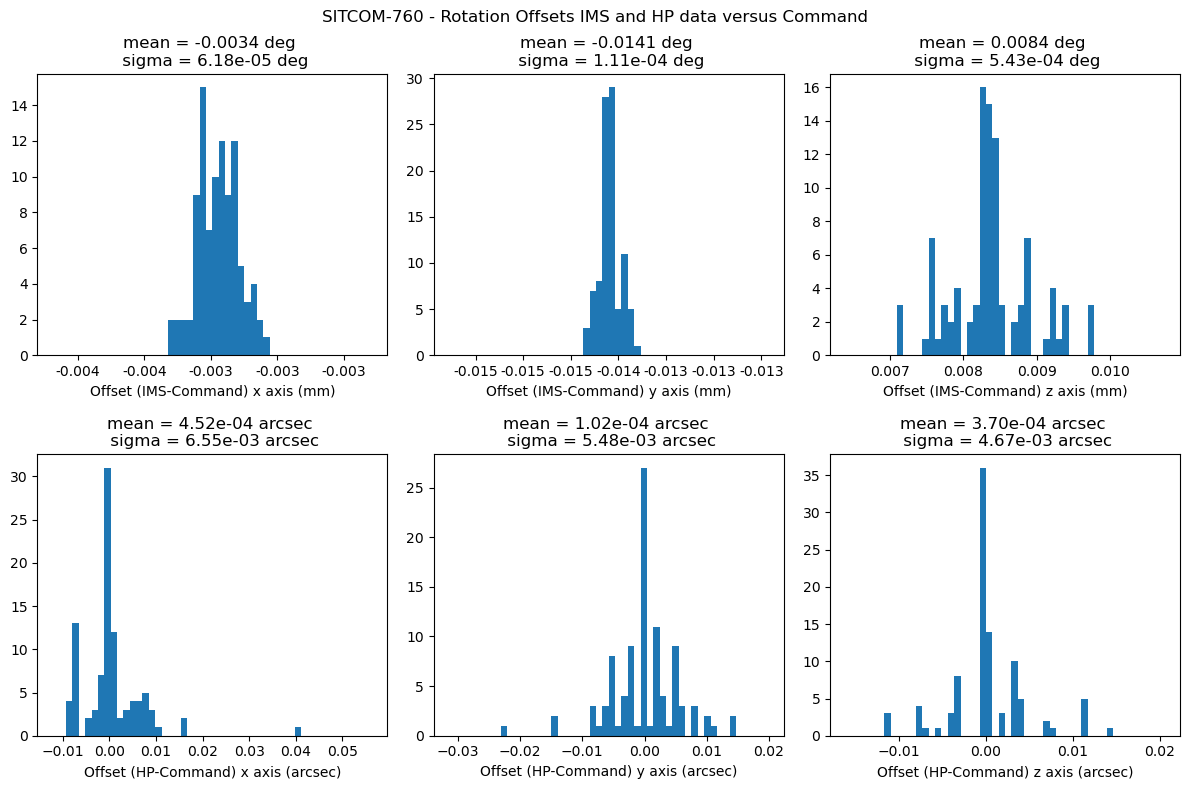

In [105]:
# Plot results for HP rotation and IMS rotation w.r.t. COMMAND rotation

title = "SITCOM-760 - Rotation Offsets IMS and HP data versus Command"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(12, 8))

axes = "xyz"
for i in range(3):
    max = np.max(results_rot[f"ims_{axes[i]}Rot_mean"]-results_rot[f"cmd_{axes[i]}Rot"])
    min = np.min(results_rot[f"ims_{axes[i]}Rot_mean"]-results_rot[f"cmd_{axes[i]}Rot"])
    axs[0][i].hist(results_rot[f"ims_{axes[i]}Rot_mean"]-results_rot[f"cmd_{axes[i]}Rot"], bins=50, range=[min-0.1*abs(min), max+0.1*abs(max)])
    axs[0][i].set_xlabel(f"Offset (IMS-Command) {axes[i]} axis (mm)")
    mean_ims_cmd_rot = np.mean(results_rot[f"ims_{axes[i]}Rot_mean"]-results_rot[f"cmd_{axes[i]}Rot"])
    sigma_ims_cmd_rot = np.std(results_rot[f"ims_{axes[i]}Rot_mean"]-results_rot[f"cmd_{axes[i]}Rot"])
    axs[0][i].set_title("mean = %.4f deg \n sigma = %.2e deg" %(mean_ims_cmd_rot, sigma_ims_cmd_rot))
    axs[0][i].xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    max = np.max(results_rot[f"HP_{axes[i]}Rot_mean"]-results_rot[f"cmd_{axes[i]}Rot"])*u.deg.to(u.arcsec)
    min = np.min(results_rot[f"HP_{axes[i]}Rot_mean"]-results_rot[f"cmd_{axes[i]}Rot"])*u.deg.to(u.arcsec)
    axs[1][i].hist((results_rot[f"HP_{axes[i]}Rot_mean"]-results_rot[f"cmd_{axes[i]}Rot"])*u.deg.to(u.arcsec), bins=50, range=[min-0.4*abs(min), max+0.4*abs(max)])
    axs[1][i].set_xlabel(f"Offset (HP-Command) {axes[i]} axis (arcsec)")
    mean_HP_cmd = np.mean((results_rot[f"HP_{axes[i]}Rot_mean"]-results_rot[f"cmd_{axes[i]}Rot"])*u.deg.to(u.arcsec))
    sigma_HP_cmd = np.std((results_rot[f"HP_{axes[i]}Rot_mean"]-results_rot[f"cmd_{axes[i]}Rot"])*u.deg.to(u.arcsec))
    axs[1][i].set_title("mean = %.2e arcsec \n sigma = %.2e arcsec" %(mean_HP_cmd, sigma_HP_cmd))
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.90)